# Libraries

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import cv2
import random
from enum import Enum
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
import csv

In [ ]:
# !pip install -U retinaface_pytorch > /dev/null

In [155]:
from retinaface.pre_trained_models import get_model as get_detector

face_detector = get_detector("resnet50_2020-07-20", max_size=512)
face_detector.eval()

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.8/site-packages/torch/hub.py:651: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


In [7]:
class MaskLabels(int, Enum):
    MASK = 0
    INCORRECT = 1
    NORMAL = 2


class GenderLabels(int, Enum):
    MALE = 0
    FEMALE = 1

    @classmethod
    def from_str(cls, value: str) -> int:
        value = value.lower()
        if value == "male":
            return cls.MALE
        elif value == "female":
            return cls.FEMALE
        else:
            raise ValueError(f"Gender value should be either 'male' or 'female', {value}")


class AgeLabels(int, Enum):
    YOUNG = 0
    MIDDLE = 1
    OLD = 2

    @classmethod
    def from_number(cls, value: str) -> int:
        try:
            value = int(value)
        except Exception:
            raise ValueError(f"Age value should be numeric, {value}")

        if value < 30:
            return cls.YOUNG
        elif value < 60:
            return cls.MIDDLE
        else:
            return cls.OLD

# face bounding boxes for training data

In [132]:
train_img_dir = './input/data/train/images'

In [156]:
class MaskBaseDataset(data.Dataset):
    num_classes = 3 * 2 * 3

    _file_names = {
        "mask1": MaskLabels.MASK,
        "mask2": MaskLabels.MASK,
        "mask3": MaskLabels.MASK,
        "mask4": MaskLabels.MASK,
        "mask5": MaskLabels.MASK,
        "incorrect_mask": MaskLabels.INCORRECT,
        "normal": MaskLabels.NORMAL
    }

    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []

    def __init__(self, img_dir):
        self.img_dir = img_dir

        self.setup()
        
    def setup(self):
        profiles = os.listdir(self.img_dir)
        for profile in profiles:
            if profile.startswith("."):  # "." 로 시작하는 파일은 무시합니다
                continue

            img_folder = os.path.join(self.img_dir, profile)
            for file_name in os.listdir(img_folder):
                _file_name, ext = os.path.splitext(file_name)
                if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                    continue

                img_path = os.path.join(self.img_dir, profile, file_name)
                mask_label = self._file_names[_file_name]

                id, gender, race, age = profile.split("_")
                gender_label = GenderLabels.from_str(gender)
                age_label = AgeLabels.from_number(age)

                self.image_paths.append(img_path)
                self.mask_labels.append(mask_label)
                self.gender_labels.append(gender_label)
                self.age_labels.append(age_label)

    def __getitem__(self, index):
        # 이미지를 불러옵니다.
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        
        # 레이블을 불러옵니다.
        mask_label = self.mask_labels[index]
        gender_label = self.gender_labels[index]
        age_label = self.age_labels[index]
        multi_class_label = mask_label * 6 + gender_label * 3 + age_label
        
        return np.array(image), multi_class_label, image_path

    def __len__(self):
        return len(self.image_paths)

In [157]:
dataset = MaskBaseDataset(img_dir=train_img_dir)

In [158]:
total_dataset, _ = data.random_split(dataset, [1, 0])

/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataset.py:342: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [159]:
total_loader = data.DataLoader(
    total_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=False
)

In [176]:
img_paths = []
x_mins = []
y_mins = []
x_maxs = []
y_maxs = []

for batch in total_loader:
    inputs, labels, img_path = batch
    
    for i, img in enumerate(inputs):
        img_paths.append(img_path[i])
        annotations = face_detector.predict_jsons(np.array(img))
        
        try:
            x_min, y_min, x_max, y_max = annotations[0]["bbox"]
            x_mins.append(x_min)
            y_mins.append(y_min)
            x_maxs.append(x_max)
            y_maxs.append(y_max)
        except:
            x_mins.append(0)
            y_mins.append(0)
            x_maxs.append(0)
            y_maxs.append(0)

## test visulization

In [177]:
# For test
x_min, y_min, x_max, y_max = x_mins[0], y_mins[0], x_maxs[0], y_maxs[0]
test=np.array(Image.open(img_paths[0]))[int(y_min):int(y_max), int(x_min):int(x_max)]

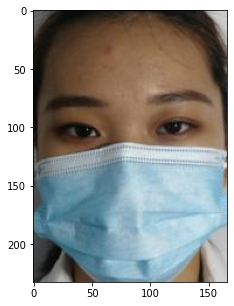

In [178]:
plt.figure(figsize = (5,5))
plt.imshow(test)

## save as csv

In [179]:
df = pd.DataFrame({'img_paths':img_paths, 'x_min':x_mins, 'y_min':y_mins, 'x_max':x_maxs, 'y_max':y_maxs})

In [180]:
df.to_csv('./bounding_box.csv', index=False)

## Visualizing Data Augmentations

In [374]:
bounding_box = pd.read_csv('./bounding_box.csv')

In [375]:
bounding_box.set_index('img_paths', inplace=True)

In [ ]:
bounding_box.loc['./input/data/train/images/001060_female_Asian_25/mask2.jpg']

In [378]:
class MaskBaseDataset(data.Dataset):
    num_classes = 3 * 2 * 3

    _file_names = {
        "mask1": MaskLabels.MASK,
        "mask2": MaskLabels.MASK,
        "mask3": MaskLabels.MASK,
        "mask4": MaskLabels.MASK,
        "mask5": MaskLabels.MASK,
        "incorrect_mask": MaskLabels.INCORRECT,
        "normal": MaskLabels.NORMAL
    }

    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []

    def __init__(self, img_dir, transform=None):
        """
        MaskBaseDataset을 initialize 합니다.

        Args:
            img_dir: 학습 이미지 폴더의 root directory 입니다.
            transform: Augmentation을 하는 함수입니다.
        """
        self.img_dir = img_dir
        self.transform = transform

        self.setup()
        
    def set_transform(self, transform):
        """
        transform 함수를 설정하는 함수입니다.
        """
        self.transform = transform
        
    def setup(self):
        """
        image의 경로와 각 이미지들의 label을 계산하여 저장해두는 함수입니다.
        """
        profiles = os.listdir(self.img_dir)
        for profile in profiles:
            if profile.startswith("."):  # "." 로 시작하는 파일은 무시합니다
                continue

            img_folder = os.path.join(self.img_dir, profile)
            for file_name in os.listdir(img_folder):
                _file_name, ext = os.path.splitext(file_name)
                if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                    continue

                img_path = os.path.join(self.img_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                mask_label = self._file_names[_file_name]

                id, gender, race, age = profile.split("_")
                gender_label = GenderLabels.from_str(gender)
                age_label = AgeLabels.from_number(age)

                self.image_paths.append(img_path)
                self.mask_labels.append(mask_label)
                self.gender_labels.append(gender_label)
                self.age_labels.append(age_label)

    def __getitem__(self, index):
        """
        데이터를 불러오는 함수입니다. 
        데이터셋 class에 데이터 정보가 저장되어 있고, index를 통해 해당 위치에 있는 데이터 정보를 불러옵니다.
        -
        Args:
            index: 불러올 데이터의 인덱스값입니다.
        """
        # 이미지를 불러옵니다.
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        image = np.array(image)
        
        if sum(bounding_box.iloc[index,1:]):
            x_min, y_min, x_max, y_max = bounding_box.loc[image_path]
            image = image[int(y_min):int(y_max), int(x_min):int(x_max)]
        else:
            pass
        
        # 레이블을 불러옵니다.
        mask_label = self.mask_labels[index]
        gender_label = self.gender_labels[index]
        age_label = self.age_labels[index]
        multi_class_label = mask_label * 6 + gender_label * 3 + age_label
        
        # 이미지를 Augmentation 시킵니다.
        image_transform = self.transform(image=np.array(image))['image']
        return image_transform, multi_class_label

    def __len__(self):
        return len(self.image_paths)

In [379]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.CLAHE(p=0.5),
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.56, 0.524, 0.501), std=(0.233, 0.243, 0.246)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.56, 0.524, 0.501), std=(0.233, 0.243, 0.246)),
    ToTensorV2(),
])

In [380]:
dataset = MaskBaseDataset(img_dir=train_img_dir)

In [381]:
# train dataset과 validation dataset을 7:3 비율로 나눕니다.
n_val = int(len(dataset) * 0.3)
n_train = len(dataset) - n_val
train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])

In [382]:
train_dataset.dataset.set_transform(train_transform)
val_dataset.dataset.set_transform(val_transform)

In [383]:
# training dataloader은 데이터를 섞어주어야 합니다. (shuffle=True)
train_loader = data.DataLoader(
    train_dataset,
    batch_size=12,
    num_workers=0,
    shuffle=True
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=False
)

In [ ]:
images, labels = next(iter(train_loader))
print(f'images shape: {images.shape}')
print(f'labels shape: {labels.shape}')

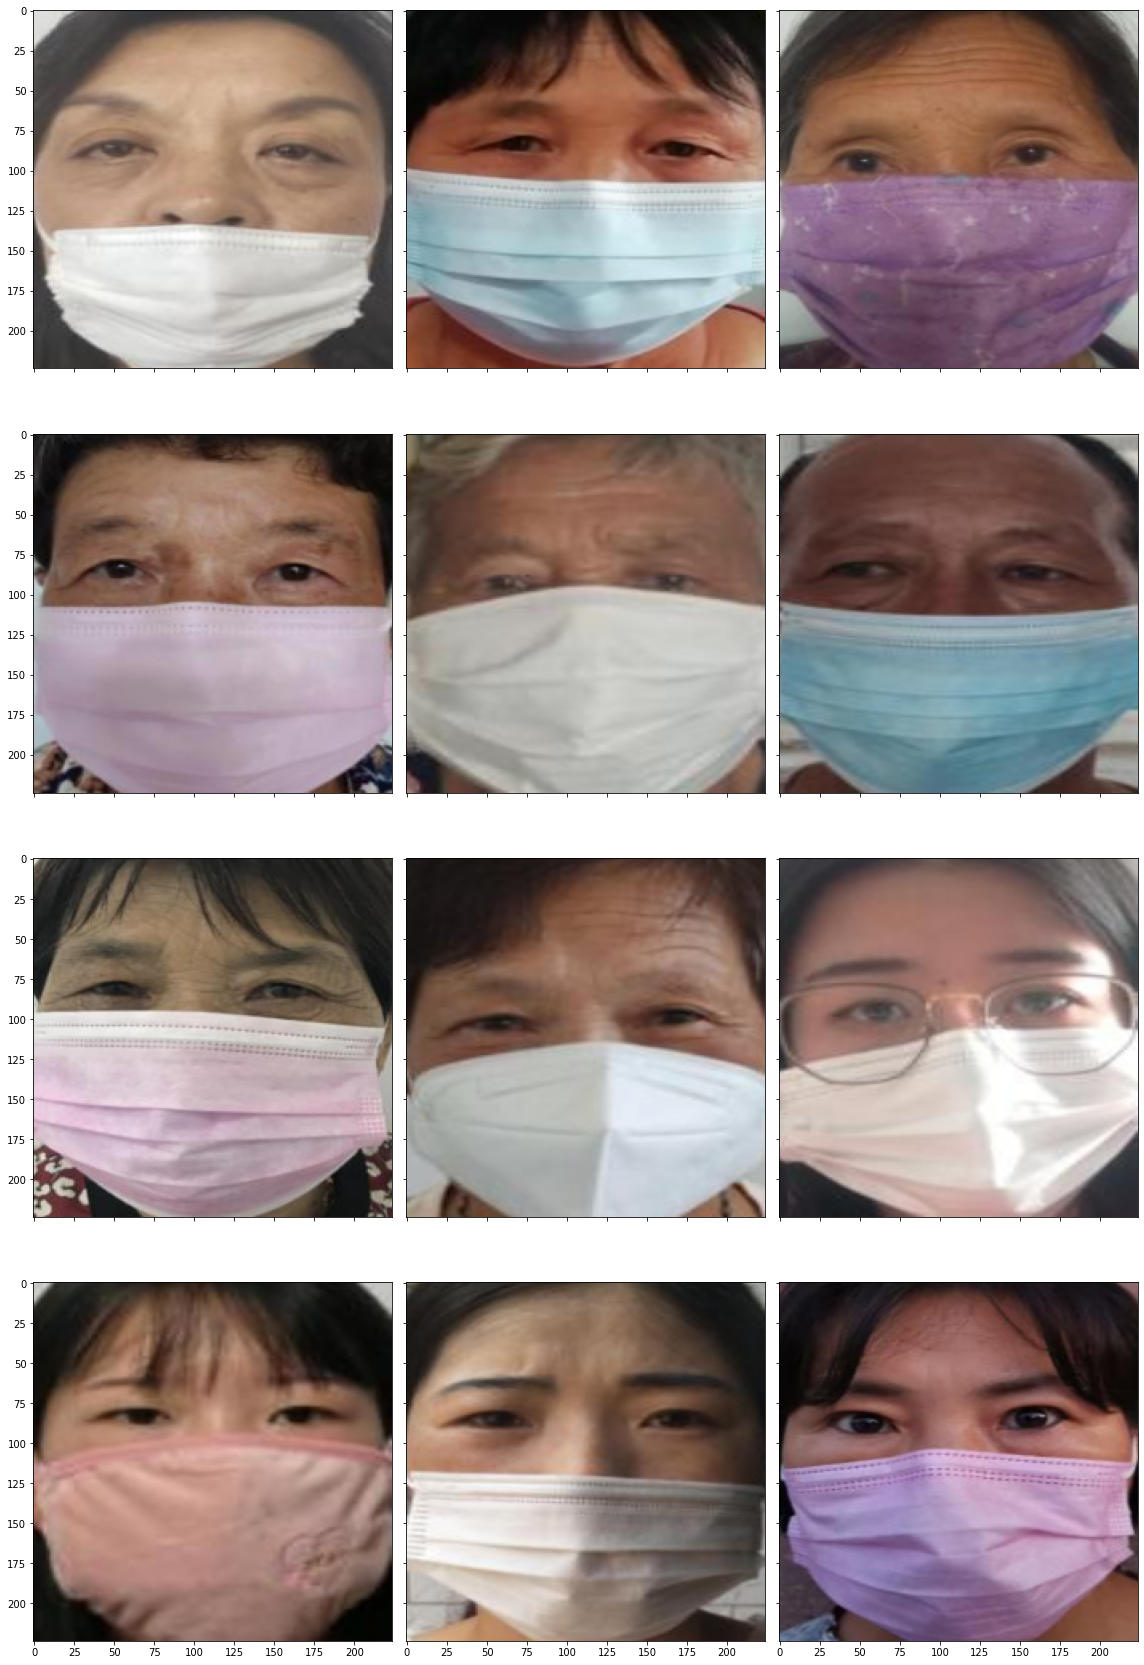

In [286]:
from torchvision import transforms

# Augmentation으로 이미지를 Normalize했기 때문에, 역으로 다시 Normalize
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip((0.56, 0.524, 0.501), (0.233, 0.243, 0.246))],
    std=[1 / s for s in (0.233, 0.243, 0.246)]
)

n_rows, n_cols = 4, 3

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(16, 24))
for i in range(n_rows*n_cols):
    axes[i%n_rows][i//(n_cols+1)].imshow(inv_normalize(images[i]).permute(1, 2, 0))
    #axes[i%n_rows][i//(n_cols+1)].set_title(f'Label: {labels[i]}', color='r')
plt.tight_layout()

In [ ]:
# 베이스라인 코드에 맞게 경로 수정
bounding_box = pd.read_csv('./bounding_box.csv')
image_path = bounding_box["img_paths"].values
for i in range(len(image_path)):
    image_path[i] = '/opt/ml'+image_path[i][1:]

In [ ]:
bounding_box.to_csv('./bounding_box.csv', index=False)

# face bounding boxes for test data

In [362]:
data_dir = './input/data/eval'
img_root = os.path.join(data_dir, 'images')
info_path = os.path.join(data_dir, 'info.csv')
info = pd.read_csv(info_path)

In [363]:
class TestDataset(Dataset):
    def __init__(self, img_paths):
        self.img_paths = img_paths
        
    def __getitem__(self, index):
        image_path = self.img_paths[index]
        image = np.array(Image.open(image_path))
        return image, image_path

    def __len__(self):
        return len(self.img_paths)

In [364]:
img_paths = [os.path.join(img_root, img_id) for img_id in info.ImageID]
dataset = TestDataset(img_paths)

In [365]:
total_dataset, _ = data.random_split(dataset, [1, 0])

/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataset.py:342: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [366]:
total_loader = data.DataLoader(
    total_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=False
)

In [296]:
img_paths = []
x_mins = []
y_mins = []
x_maxs = []
y_maxs = []

for batch in total_loader:
    inputs, img_path = batch
    
    for i, img in enumerate(inputs):
        img_paths.append(img_path[i])
        annotations = face_detector.predict_jsons(np.array(img))
        
        try:
            x_min, y_min, x_max, y_max = annotations[0]["bbox"]
            x_mins.append(x_min)
            y_mins.append(y_min)
            x_maxs.append(x_max)
            y_maxs.append(y_max)
        except:
            x_mins.append(0)
            y_mins.append(0)
            x_maxs.append(0)
            y_maxs.append(0)

## test visulization

In [302]:
# For test
x_min, y_min, x_max, y_max = x_mins[0], y_mins[0], x_maxs[0], y_maxs[0]
test=np.array(Image.open(img_paths[0]))[int(y_min):int(y_max), int(x_min):int(x_max)]

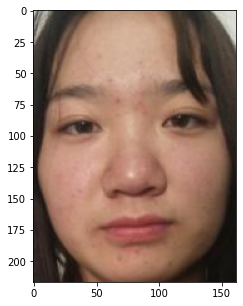

In [303]:
plt.figure(figsize = (5,5))
plt.imshow(test)

## save as csv

In [304]:
df_test = pd.DataFrame({'img_paths':img_paths, 'x_min':x_mins, 'y_min':y_mins, 'x_max':x_maxs, 'y_max':y_maxs})

In [337]:
df_test

,img_paths,x_min,y_min,x_max,y_max
0,./input/data/eval/images/47f2a06e62e3d9ba5cfd2...,113.73,74.34,275.24,291.96
1,./input/data/eval/images/0d2acf1953d2aa6a72142...,119.71,154.21,257.00,347.04
2,./input/data/eval/images/d055af2eabf67333dd4cc...,143.29,81.19,305.78,302.25
3,./input/data/eval/images/969776304bfaea84c23e2...,130.99,194.98,245.81,357.61
4,./input/data/eval/images/afa73b5d5c38ff2bdbcdf...,91.20,129.08,290.58,406.33
...,...,...,...,...,...
12595,./input/data/eval/images/73f0a9543f05a8cb00ed0...,126.44,198.54,267.49,399.15
12596,./input/data/eval/images/3010891cb4c98e957cf49...,124.21,173.91,256.05,356.67
12597,./input/data/eval/images/6f5a8fa9a90040843f2ba...,115.99,189.46,251.58,379.02
12598,./input/data/eval/images/c09c47d5799ee8c8e4150...,124.48,167.24,261.25,352.04


In [346]:
# 경로 수정
image_path = df_test["img_paths"].values
for i in range(len(image_path)):
    image_path[i] = '/opt/ml'+image_path[i][1:]

In [350]:
df_test.to_csv('./bounding_box_test.csv', index=False)

## test visulization

In [354]:
bounding_box_test = pd.read_csv('./bounding_box_test.csv')

In [356]:
bounding_box_test.set_index('img_paths', inplace=True)

In [360]:
x_min, y_min, x_max, y_max = bounding_box_test.loc[image_path[16]].values
print(x_min, y_min, x_max, y_max)

88.99 172.31 262.33 420.35


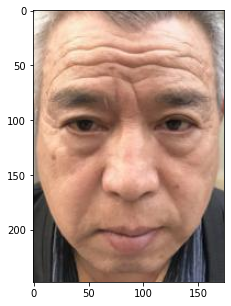

In [361]:
test=np.array(Image.open(img_paths[16]))[int(y_min):int(y_max), int(x_min):int(x_max)]

plt.figure(figsize = (5,5))
plt.imshow(test)